In [2]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline


## H5 Extraction functions

In [3]:
N_ELECTRODES = 32
CUT_OFF = 120
STEP_CUT_OFF = 100

def find_sublist(sub, bigger):
    if not bigger:
        return -1
    if not sub:
        return 0
    first, rest = sub[0], sub[1:]
    pos = 0
    try:
        while True:
            pos = bigger.index(first, pos) + 1
            if not rest or bigger[pos:pos+len(rest)] == rest:
                return pos
    except ValueError:
        return -1 

def get_raw_data(path: str, result, index) -> np.ndarray:
    f = h5py.File(path, mode='r')
    X = []
    Y = []

    print(f'\nNum electrode : {index}')
    spike_windows = f[f'SpikeWindow-0.{index}'][()]
    print(len(spike_windows))
    dataRaw = f[f'Raw-0.{index}'][0:len(f[f'Raw-0.{index}']):1, 1]
    sp = []

    K = len(spike_windows)
    for indx,spke in enumerate(spike_windows):
        tmp = find_sublist(spke.tolist(), dataRaw.tolist())
        if(tmp != -1):
            sp.append(tmp + 30)
    
    print(f'\nEnd find_sublist : {index}')
        
    for i in range(0,len(dataRaw)-CUT_OFF,STEP_CUT_OFF):
        range_cut_off = dataRaw[i:i+CUT_OFF]
        if(not any(x in sp for x in range(i,i+CUT_OFF))):
            Y.append(0)
        else:
            Y.append(1)
        X.append(range_cut_off)
    result[index] = [X,Y]
    
def get_noise_data(path: str,shape:int,arr: np.ndarray) -> np.ndarray:
    f = h5py.File(path, mode='r')
    X = []
    Y = []

    for index in arr:
        print(f'\nNum electrode : {index}')
        spike_windows = f[f'SpikeWindow-0.{index}'][()]
        print(len(spike_windows))
        dataRaw = f[f'Raw-0.{index}'][0:len(f[f'Raw-0.{index}']):1, 1]
        sp = []

        K = len(spike_windows)
        for indx,spke in enumerate(spike_windows):
            tmp = find_sublist(spke.tolist(), dataRaw.tolist())
            if(tmp != -1):
                sp.append(tmp + 30)
            print(end="\r|%-80s|" % ("="*int(80*indx/(K-1))))
        
        for i in range(0,len(dataRaw)-CUT_OFF,CUT_OFF):
            if(len(X) == shape):
                return X
            range_cut_off = dataRaw[i:i+CUT_OFF]
            if(not any(x in sp for x in range(i,i+CUT_OFF))):
                X.append(range_cut_off)



def get_spike_data(path: str, arr: np.ndarray) -> np.ndarray:
    f = h5py.File(path, mode='r')
    sp = []

    for index in arr:
        print(f'\nNum electrode : {index}')
        spike_windows = f[f'SpikeWindow-0.{index}'][()]

        K = len(spike_windows)
        print(K)
        for indx,spke in enumerate(spike_windows):
            sp.append(spke[0:CUT_OFF])
            if(K != 1):
                print(end="\r|%-80s|" % ("="*int(80*indx/(K-1))))
    return sp

def get_number_spike_raw_data(path: str) -> np.ndarray:
    f = h5py.File(path, mode='r')
    event = 0
    for n in f.keys():
        if("SpikeTimestamp-0" in n):
            event += f[n].shape[0]
    return event

In [4]:
import threading
node = [7,26,31]
th = []
results = [None] * N_ELECTRODES

for i in [26,31]:
    t = threading.Thread(target = get_raw_data, args = ['./Post TBI 3/2022-11-23T16-55-00_SpikeOnChip_SPOC1_Data_Clean.h5',results, i])
    t.start()
    th.append(t)

print(f'Active Threads: {threading.active_count()}')
for t in th:
    t.join()


Num electrode : 26
Active Threads: 8
Num electrode : 31

189565


End find_sublist : 31

End find_sublist : 26


In [9]:
np.savetxt("x_raw_1_"+str(CUT_OFF)+".csv", results[26][0], delimiter=",")
np.savetxt("y_raw_1_"+str(CUT_OFF)+".csv", results[26][1], delimiter=",")

In [5]:
arr = []
for i in range(N_ELECTRODES):
    print(len(results[i]))
    arr.extend(results[i])

print(len(arr))

1850
636
2062
1496
418
900
1776
1424
1428
2634
784
24
681
3225
540
457
276
341
462
325
313
670
108
583
109
5
56
472
567
152
685
61
25520


In [6]:
x_raw_noise, y_raw_noise = get_noise_raw_data('./RAW/2021-05-07T12-30-00_SpikeOnChip_Data.h5')


Num electrode : 0


KeyboardInterrupt: 

In [ ]:
print(x_raw_noise.shape)

AttributeError: 'list' object has no attribute 'shape'

In [8]:
all_spikes = pd.DataFrame(arr)
all_noises = pd.DataFrame(x_raw_noise)

spike_noise_ratio = all_spikes.shape[0] / all_noises.shape[0]
print(f"Got a {spike_noise_ratio:.1%} spike to noise ratio")

NameError: name 'x_raw_noise' is not defined

## Show some exemple for a spike

C:\Users\ti-xa\AppData\Local\Temp\ipykernel_8684\228977431.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


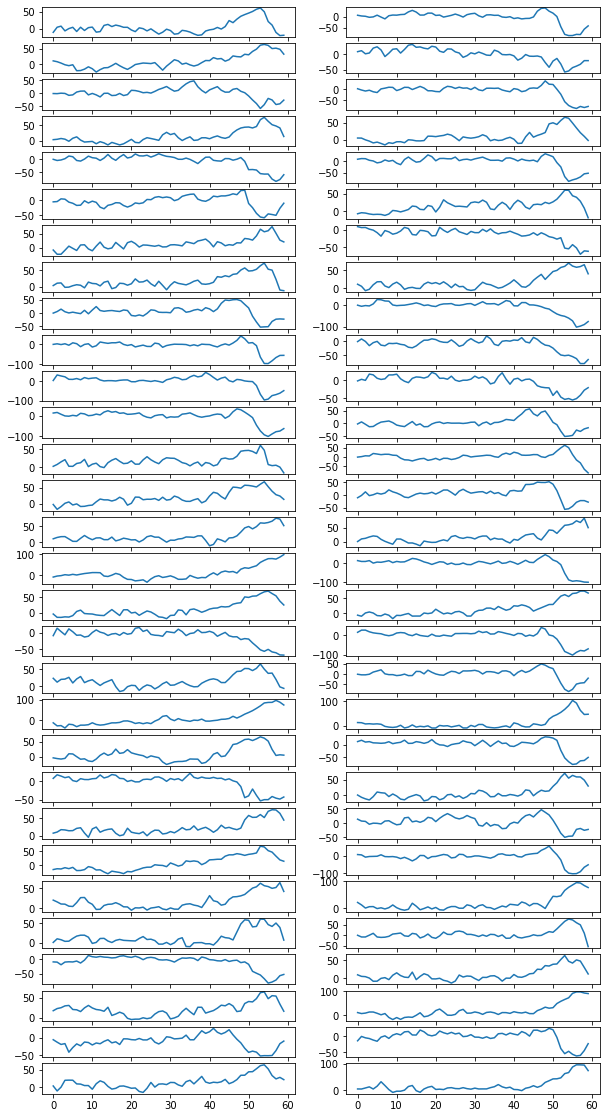

In [9]:
item = 0
tmp = -1
fig, axs = plt.subplots(30, 2)
for index, row in all_spikes.iterrows():
    if(item == 60):
        break
    fig.set_size_inches(10, 20)
    if(item%2 == 0):
        tmp += 1 
    axs[tmp,item%2].plot(row)
    item += 1
fig.show()

## Show noise sample

C:\Users\ti-xa\AppData\Local\Temp\ipykernel_12848\4146374116.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


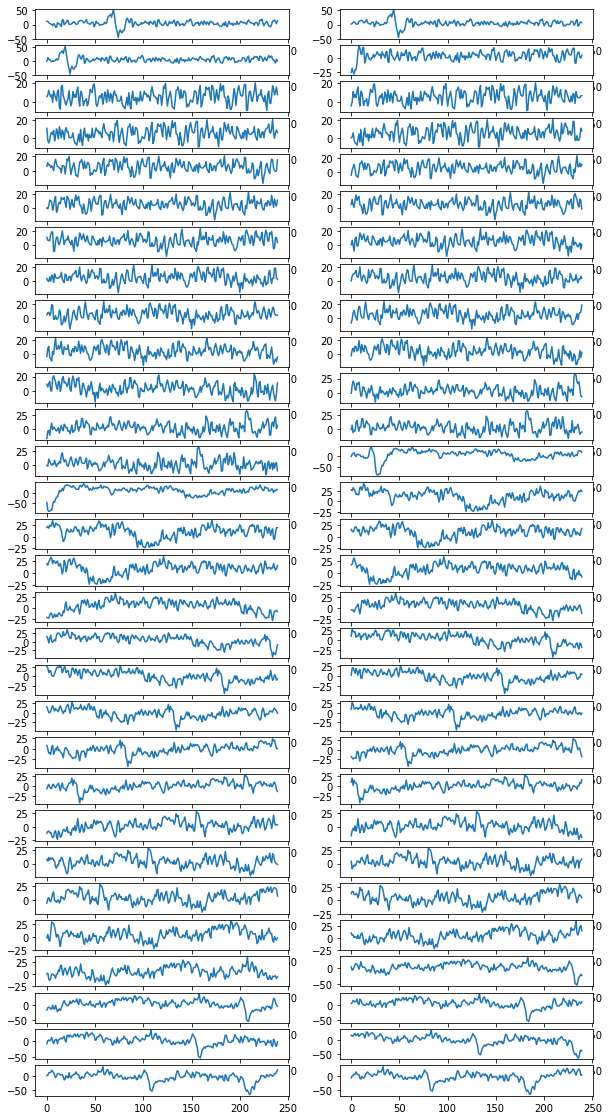

In [ ]:
item = 0
tmp = -1
fig, axs = plt.subplots(30, 2)
for index, row in all_noises.iterrows():
    if(item == 60):
        break
    fig.set_size_inches(10, 20)
    if(item%2 == 0):
        tmp += 1 
    axs[tmp,item%2].plot(row)
    item += 1
fig.show()

In [7]:
# np.savetxt("x_raw_noise"+str(CUT_OFF)+".csv", x_raw_noise, delimiter=",")
np.savetxt("x_raw_spike"+str(CUT_OFF)+".csv", arr, delimiter=",")